# RQ3: Stakeholder invocation analysis

This notebook examines which actors are invoked in AI-related parliamentary discourse: institutional actors (EU, state, industry, experts) versus citizen-focused actors (individuals, workers, communities, vulnerable groups). We compare motioner (MP proposals, bottom-up) against propositioner (government bills, top-down) to test whether government texts privilege institutional actors whilst MP proposals centre citizens and communities.

## Setup and imports

In [1]:
import re
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# set visualisation style
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10
sns.set_palette(['#9B59B6', '#E91E63', '#555555', '#AAAAAA'])

## Data loading

Parse document metadata headers and extract clean text from HTML content.

In [2]:
def parse_document(file_path):
    """extract metadata and clean text from parliamentary document."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # split metadata from html content
    parts = content.split('=' * 80)
    if len(parts) < 2:
        return None
    
    metadata_section = parts[0]
    html_content = parts[1]
    
    # parse metadata
    metadata = {}
    for line in metadata_section.strip().split('\n'):
        if ':' in line:
            key, value = line.split(':', 1)
            metadata[key.strip().lower().replace(' ', '_')] = value.strip()
    
    # extract text from html
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    
    # clean text
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'Observera att dokumentet är inskannat.*?förekomma\.?', '', text, flags=re.IGNORECASE)
    
    return {
        'document_id': metadata.get('document_id', ''),
        'title': metadata.get('title', ''),
        'type': metadata.get('type', ''),
        'date': metadata.get('date', ''),
        'parliamentary_year': metadata.get('parliamentary_year', ''),
        'text': text.strip(),
        'word_count': len(text.split())
    }

In [3]:
# load motioner
motioner_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/motioner')
motioner_files = list(motioner_dir.glob('*.txt'))

motioner_data = []
for file_path in motioner_files:
    doc = parse_document(file_path)
    if doc and doc['word_count'] > 50:  # exclude very short documents
        doc['doc_type'] = 'mot'
        motioner_data.append(doc)

print(f"loaded {len(motioner_data)} motioner")

loaded 452 motioner


In [4]:
# load propositioner
prop_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/propositioner')
prop_files = list(prop_dir.glob('*.txt'))

prop_data = []
for file_path in prop_files:
    doc = parse_document(file_path)
    if doc and doc['word_count'] > 50:
        doc['doc_type'] = 'prop'
        prop_data.append(doc)

print(f"loaded {len(prop_data)} propositioner")

loaded 700 propositioner


In [5]:
# combine into single dataframe
df = pd.DataFrame(motioner_data + prop_data)
df['text_lower'] = df['text'].str.lower()

print(f"\ntotal corpus: {len(df)} documents")
print(f"motioner: {len(df[df['doc_type'] == 'mot'])}")
print(f"propositioner: {len(df[df['doc_type'] == 'prop'])}")
print(f"\ntotal words: {df['word_count'].sum():,}")
print(f"mean document length: {df['word_count'].mean():.0f} words")


total corpus: 1152 documents
motioner: 452
propositioner: 700

total words: 62,087,566
mean document length: 53895 words


## Stakeholder dictionaries

Define keyword patterns for institutional versus citizen-focused actors. Keywords are matched as word boundaries to avoid substring matches.

In [6]:
# institutional actors
stakeholder_keywords = {
    # institutional
    'eu_international': [
        r'\beu\b', r'\beus\b', r'europeisk', r'europa', r'union', r'kommissionen', 
        r'europaparlament', r'\boecd\b', r'\bfn\b', r'internationell', r'global'
    ],
    'state_government': [
        r'regering', r'staten', r'statlig', r'departement', r'minister', 
        r'myndighet', r'riksdag', r'förvaltning'
    ],
    'industry_business': [
        r'företag', r'näringsliv', r'industri', r'bransch', r'arbetsgivare', 
        r'investera', r'startup', r'\btech\b', r'bolag', r'marknad'
    ],
    'experts_academia': [
        r'forskare', r'forskni', r'universitet', r'högskola', r'expert', 
        r'vetenskap', r'akademi', r'professor'
    ],
    
    # citizen-focused
    'citizens_individuals': [
        r'medborgare', r'individ', r'människa', r'person', r'användare', 
        r'konsument', r'patient', r'allmänhet'
    ],
    'workers_employees': [
        r'arbetstagare', r'anställd', r'arbetare', r'personal', r'fackförbund', 
        r'\bfack\b', r'\blo\b', r'\btco\b', r'facklig'
    ],
    'communities_groups': [
        r'samhälle', r'kommun', r'lokal', r'regional', r'civilsamhälle', 
        r'förening', r'organisation', r'medborgar'
    ],
    'vulnerable_groups': [
        r'\bbarn\b', r'äldre', r'funktionsnedsättning', r'utsatt', r'marginaliserad', 
        r'minoritet', r'diskriminera', r'sårbar'
    ]
}

# compile regex patterns
compiled_patterns = {}
for category, keywords in stakeholder_keywords.items():
    pattern = '|'.join(keywords)
    compiled_patterns[category] = re.compile(pattern, re.IGNORECASE)

print("stakeholder categories defined:")
print("\ninstitutional actors:")
for cat in ['eu_international', 'state_government', 'industry_business', 'experts_academia']:
    print(f"  - {cat}: {len(stakeholder_keywords[cat])} keywords")
print("\ncitizen-focused actors:")
for cat in ['citizens_individuals', 'workers_employees', 'communities_groups', 'vulnerable_groups']:
    print(f"  - {cat}: {len(stakeholder_keywords[cat])} keywords")

stakeholder categories defined:

institutional actors:
  - eu_international: 11 keywords
  - state_government: 8 keywords
  - industry_business: 10 keywords
  - experts_academia: 8 keywords

citizen-focused actors:
  - citizens_individuals: 8 keywords
  - workers_employees: 9 keywords
  - communities_groups: 8 keywords
  - vulnerable_groups: 8 keywords


## Stakeholder frequency analysis

Count mentions of each stakeholder category and normalise by document length to enable comparison across documents of varying sizes.

In [7]:
def count_stakeholder_mentions(text, patterns):
    """count mentions of each stakeholder category in text."""
    counts = {}
    for category, pattern in patterns.items():
        matches = pattern.findall(text)
        counts[category] = len(matches)
    return counts

In [8]:
# count stakeholder mentions for each document
stakeholder_counts = []

for idx, row in df.iterrows():
    counts = count_stakeholder_mentions(row['text_lower'], compiled_patterns)
    stakeholder_counts.append(counts)

# add counts to dataframe
counts_df = pd.DataFrame(stakeholder_counts)
df = pd.concat([df, counts_df], axis=1)

print(f"analysed {len(df)} documents")

analysed 1152 documents


In [9]:
# normalise by document length (per 1,000 words)
stakeholder_categories = list(stakeholder_keywords.keys())

for category in stakeholder_categories:
    df[f'{category}_norm'] = (df[category] / df['word_count']) * 1000

In [10]:
# calculate aggregate scores
institutional_categories = ['eu_international', 'state_government', 'industry_business', 'experts_academia']
citizen_categories = ['citizens_individuals', 'workers_employees', 'communities_groups', 'vulnerable_groups']

df['institutional_total'] = df[institutional_categories].sum(axis=1)
df['citizen_total'] = df[citizen_categories].sum(axis=1)

df['institutional_norm'] = df[[f'{cat}_norm' for cat in institutional_categories]].sum(axis=1)
df['citizen_norm'] = df[[f'{cat}_norm' for cat in citizen_categories]].sum(axis=1)

# calculate institutional orientation score (positive = more institutional, negative = more citizen-focused)
df['orientation_score'] = df['institutional_norm'] - df['citizen_norm']

In [11]:
# summary statistics by document type
summary_by_type = df.groupby('doc_type')[stakeholder_categories + ['institutional_total', 'citizen_total']].sum()
print("total mentions by document type:")
print(summary_by_type)

print("\nmean normalised mentions per 1,000 words:")
norm_cols = [f'{cat}_norm' for cat in stakeholder_categories] + ['institutional_norm', 'citizen_norm']
print(df.groupby('doc_type')[norm_cols].mean())

total mentions by document type:
          eu_international  state_government  industry_business  \
doc_type                                                          
mot                  13591             45884              18825   
prop                402971            611414             443752   

          experts_academia  citizens_individuals  workers_employees  \
doc_type                                                              
mot                   9059                 12388               3272   
prop                 97166                245985              42305   

          communities_groups  vulnerable_groups  institutional_total  \
doc_type                                                               
mot                    18336               8502                87359   
prop                  174092              43810              1555303   

          citizen_total  
doc_type                 
mot               42498  
prop             506192  

mean normalised men

## Visualisations

Compare stakeholder invocation patterns between motioner and propositioner.

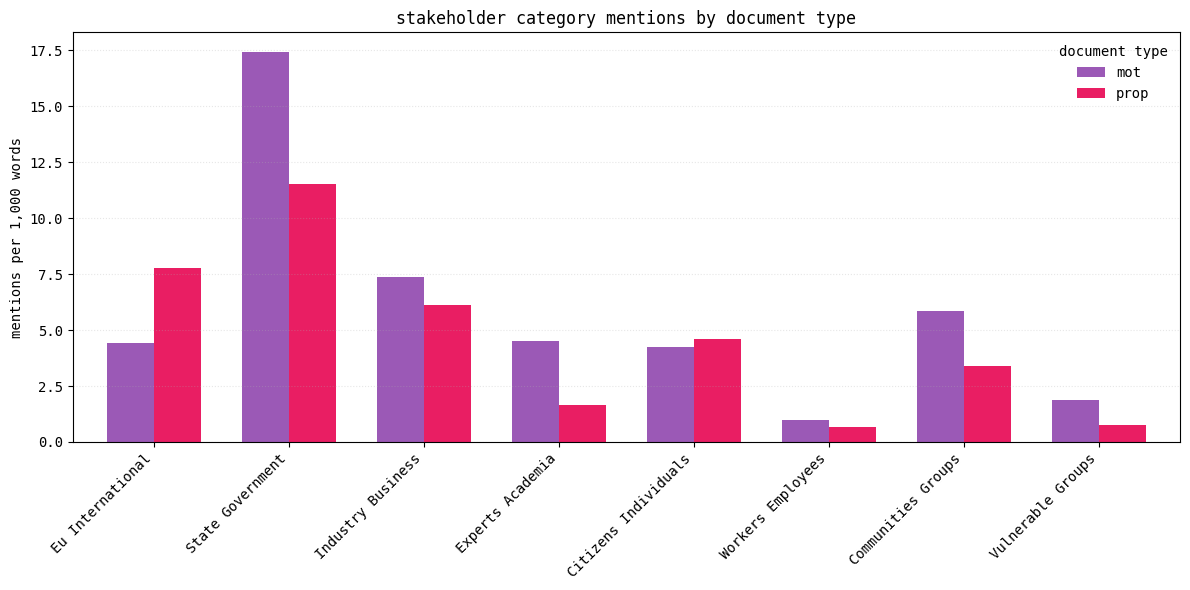

In [12]:
# prepare data for plotting
plot_data = df.groupby('doc_type')[[f'{cat}_norm' for cat in stakeholder_categories]].mean()
plot_data.columns = [cat.replace('_', ' ').title() for cat in stakeholder_categories]

# grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
plot_data.T.plot(kind='bar', ax=ax, width=0.7, color=['#9B59B6', '#E91E63'])

ax.set_xlabel('')
ax.set_ylabel('mentions per 1,000 words')
ax.set_title('stakeholder category mentions by document type', fontsize=12, fontweight='normal')
ax.legend(title='document type', frameon=False)
ax.grid(axis='y', alpha=0.3, linestyle=':')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq3_stakeholder_categories.png', 
            dpi=150, bbox_inches='tight')
plt.show()

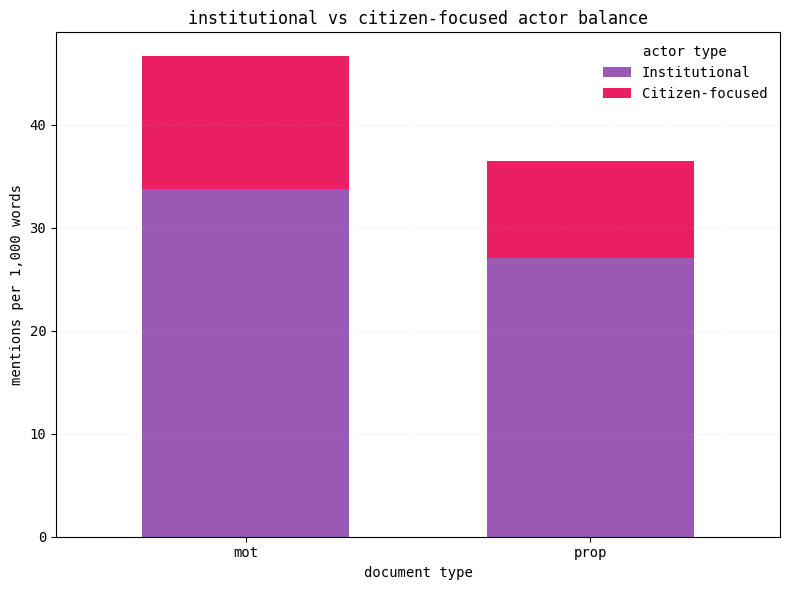


actor balance ratios (institutional:citizen):
mot: 2.61:1
prop: 2.88:1


In [13]:
# stacked bar showing institutional vs citizen balance
balance_data = df.groupby('doc_type')[['institutional_norm', 'citizen_norm']].mean()
balance_data.columns = ['Institutional', 'Citizen-focused']

fig, ax = plt.subplots(figsize=(8, 6))
balance_data.plot(kind='bar', stacked=True, ax=ax, color=['#9B59B6', '#E91E63'], width=0.6)

ax.set_xlabel('document type')
ax.set_ylabel('mentions per 1,000 words')
ax.set_title('institutional vs citizen-focused actor balance', fontsize=12, fontweight='normal')
ax.legend(title='actor type', frameon=False)
ax.grid(axis='y', alpha=0.3, linestyle=':')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq3_actor_balance.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("\nactor balance ratios (institutional:citizen):")
for doc_type in balance_data.index:
    inst = balance_data.loc[doc_type, 'Institutional']
    cit = balance_data.loc[doc_type, 'Citizen-focused']
    ratio = inst / cit if cit > 0 else float('inf')
    print(f"{doc_type}: {ratio:.2f}:1")

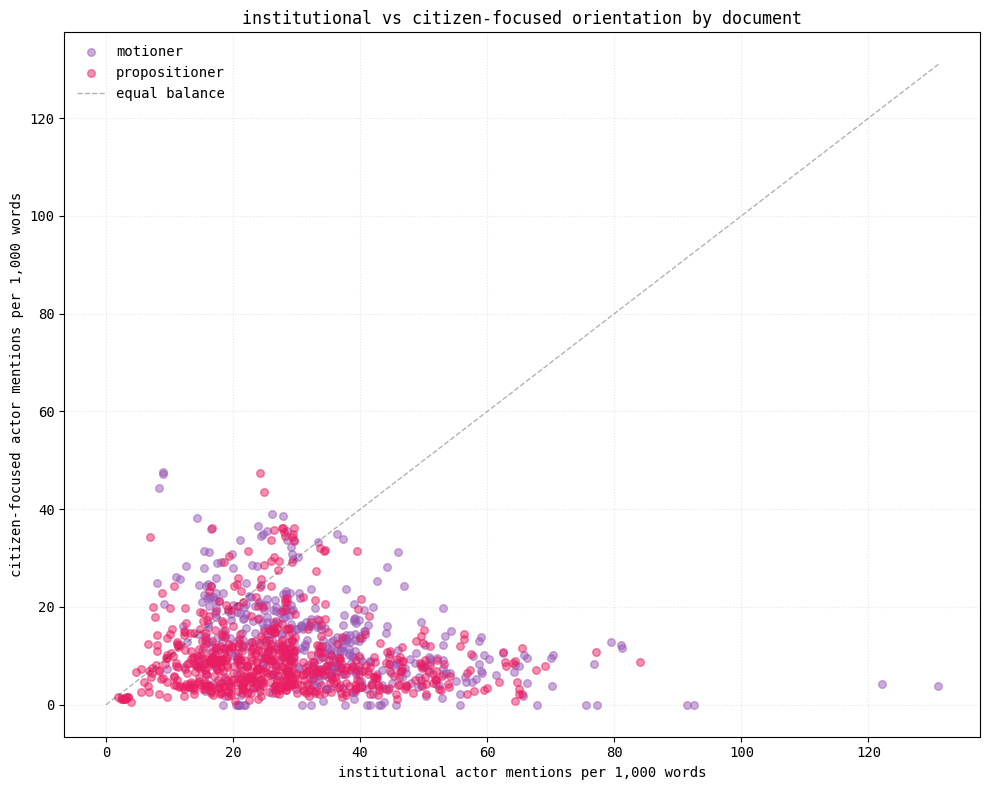

In [14]:
# scatter plot of institutional vs citizen scores
fig, ax = plt.subplots(figsize=(10, 8))

for doc_type, color, label in [('mot', '#9B59B6', 'motioner'), ('prop', '#E91E63', 'propositioner')]:
    subset = df[df['doc_type'] == doc_type]
    ax.scatter(subset['institutional_norm'], subset['citizen_norm'], 
               alpha=0.5, s=30, color=color, label=label)

# add diagonal reference line (equal balance)
max_val = max(df['institutional_norm'].max(), df['citizen_norm'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1, label='equal balance')

ax.set_xlabel('institutional actor mentions per 1,000 words')
ax.set_ylabel('citizen-focused actor mentions per 1,000 words')
ax.set_title('institutional vs citizen-focused orientation by document', fontsize=12, fontweight='normal')
ax.legend(frameon=False)
ax.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq3_orientation_scatter.png', 
            dpi=150, bbox_inches='tight')
plt.show()

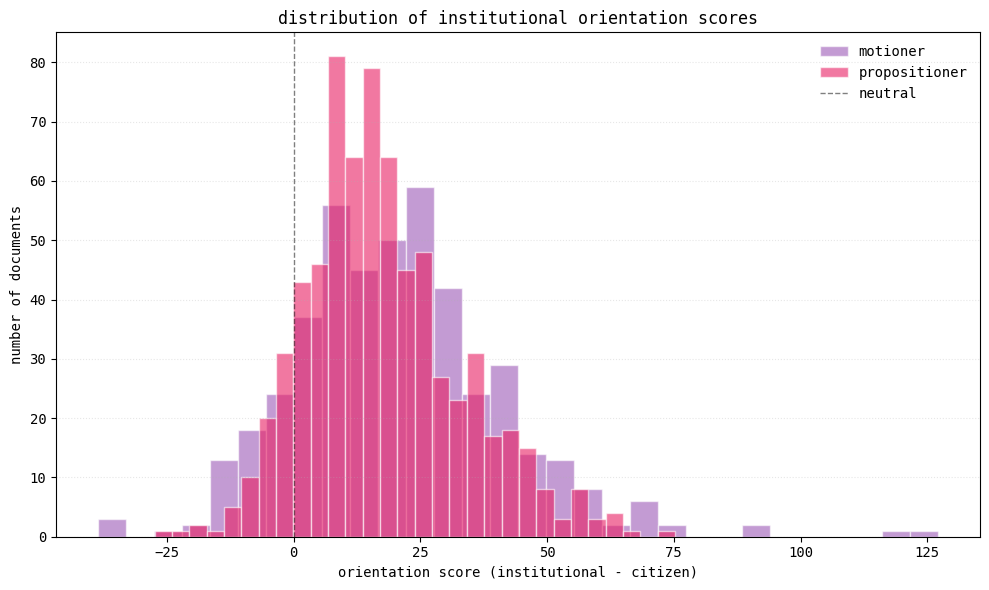


mean orientation scores:
               mean        std        min         max
doc_type                                             
mot       20.828652  20.595156 -38.560411  127.107652
prop      17.654383  15.347686 -27.369362   75.212493


In [15]:
# distribution of orientation scores
fig, ax = plt.subplots(figsize=(10, 6))

for doc_type, color, label in [('mot', '#9B59B6', 'motioner'), ('prop', '#E91E63', 'propositioner')]:
    subset = df[df['doc_type'] == doc_type]['orientation_score']
    ax.hist(subset, bins=30, alpha=0.6, color=color, label=label, edgecolor='white')

ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='neutral')
ax.set_xlabel('orientation score (institutional - citizen)')
ax.set_ylabel('number of documents')
ax.set_title('distribution of institutional orientation scores', fontsize=12, fontweight='normal')
ax.legend(frameon=False)
ax.grid(axis='y', alpha=0.3, linestyle=':')
plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq3_orientation_distribution.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("\nmean orientation scores:")
print(df.groupby('doc_type')['orientation_score'].describe()[['mean', 'std', 'min', 'max']])

## Statistical comparison

Identify which stakeholder categories show the largest differences between document types.

In [16]:
from scipy import stats

# compare each category between document types
comparison_results = []

for category in stakeholder_categories:
    mot_vals = df[df['doc_type'] == 'mot'][f'{category}_norm']
    prop_vals = df[df['doc_type'] == 'prop'][f'{category}_norm']
    
    # mann-whitney u test (non-parametric)
    statistic, pvalue = stats.mannwhitneyu(mot_vals, prop_vals, alternative='two-sided')
    
    # effect size (cohen's d)
    mean_diff = mot_vals.mean() - prop_vals.mean()
    pooled_std = np.sqrt((mot_vals.std()**2 + prop_vals.std()**2) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
    
    comparison_results.append({
        'category': category,
        'mot_mean': mot_vals.mean(),
        'prop_mean': prop_vals.mean(),
        'difference': mean_diff,
        'cohens_d': cohens_d,
        'p_value': pvalue,
        'significant': pvalue < 0.05
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('cohens_d', ascending=False)

print("stakeholder category comparison (motioner vs propositioner):")
print("\npositive difference = higher in motioner, negative = higher in propositioner")
print(comparison_df.to_string(index=False))

stakeholder category comparison (motioner vs propositioner):

positive difference = higher in motioner, negative = higher in propositioner
            category  mot_mean  prop_mean  difference  cohens_d      p_value  significant
    state_government 17.437235  11.510343    5.926892  0.805759 2.352108e-47         True
  communities_groups  5.861834   3.390149    2.471685  0.584308 1.785003e-29         True
   vulnerable_groups  1.865901   0.745892    1.120009  0.481064 2.599010e-05         True
    experts_academia  4.521429   1.668220    2.853208  0.334990 3.206860e-15         True
   workers_employees  0.961748   0.679844    0.281904  0.170609 4.980008e-01        False
   industry_business  7.380783   6.112469    1.268314  0.159029 1.476540e-05         True
citizens_individuals  4.222213   4.581793   -0.359580 -0.070130 3.358014e-01        False
    eu_international  4.400902   7.761029   -3.360127 -0.463105 1.179035e-24         True


In [17]:
# compare aggregate scores
print("\naggregate actor type comparison:")
print("\ninstitutional actors:")
mot_inst = df[df['doc_type'] == 'mot']['institutional_norm']
prop_inst = df[df['doc_type'] == 'prop']['institutional_norm']
stat, pval = stats.mannwhitneyu(mot_inst, prop_inst)
print(f"  motioner mean: {mot_inst.mean():.2f}")
print(f"  propositioner mean: {prop_inst.mean():.2f}")
print(f"  difference: {mot_inst.mean() - prop_inst.mean():.2f}")
print(f"  p-value: {pval:.4f}")

print("\ncitizen-focused actors:")
mot_cit = df[df['doc_type'] == 'mot']['citizen_norm']
prop_cit = df[df['doc_type'] == 'prop']['citizen_norm']
stat, pval = stats.mannwhitneyu(mot_cit, prop_cit)
print(f"  motioner mean: {mot_cit.mean():.2f}")
print(f"  propositioner mean: {prop_cit.mean():.2f}")
print(f"  difference: {mot_cit.mean() - prop_cit.mean():.2f}")
print(f"  p-value: {pval:.4f}")

print("\norientation score:")
mot_orient = df[df['doc_type'] == 'mot']['orientation_score']
prop_orient = df[df['doc_type'] == 'prop']['orientation_score']
stat, pval = stats.mannwhitneyu(mot_orient, prop_orient)
print(f"  motioner mean: {mot_orient.mean():.2f}")
print(f"  propositioner mean: {prop_orient.mean():.2f}")
print(f"  difference: {mot_orient.mean() - prop_orient.mean():.2f}")
print(f"  p-value: {pval:.4f}")


aggregate actor type comparison:

institutional actors:
  motioner mean: 33.74
  propositioner mean: 27.05
  difference: 6.69
  p-value: 0.0000

citizen-focused actors:
  motioner mean: 12.91
  propositioner mean: 9.40
  difference: 3.51
  p-value: 0.0000

orientation score:
  motioner mean: 20.83
  propositioner mean: 17.65
  difference: 3.17
  p-value: 0.0058


## Export results

Save document-level stakeholder data and category comparison statistics for further analysis.

In [18]:
# create results directory if needed
results_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results')
results_dir.mkdir(exist_ok=True)

In [19]:
# export document-level data
export_cols = ['document_id', 'title', 'doc_type', 'date', 'parliamentary_year', 'word_count'] + \
              stakeholder_categories + \
              [f'{cat}_norm' for cat in stakeholder_categories] + \
              ['institutional_total', 'citizen_total', 'institutional_norm', 'citizen_norm', 'orientation_score']

df[export_cols].to_csv(
    results_dir / 'rq3_document_stakeholders.csv',
    index=False,
    encoding='utf-8'
)

print(f"exported document-level data: {len(df)} documents")

exported document-level data: 1152 documents


In [20]:
# export category comparison
comparison_df.to_csv(
    results_dir / 'rq3_stakeholder_comparison.csv',
    index=False,
    encoding='utf-8'
)

print(f"exported stakeholder comparison: {len(comparison_df)} categories")

exported stakeholder comparison: 8 categories


In [21]:
# summary statistics for quick reference
summary = {
    'corpus_stats': {
        'total_documents': len(df),
        'motioner': len(df[df['doc_type'] == 'mot']),
        'propositioner': len(df[df['doc_type'] == 'prop']),
        'total_words': int(df['word_count'].sum())
    },
    'mean_mentions_per_1k_words': {
        'motioner': {
            'institutional': float(df[df['doc_type'] == 'mot']['institutional_norm'].mean()),
            'citizen_focused': float(df[df['doc_type'] == 'mot']['citizen_norm'].mean()),
            'orientation_score': float(df[df['doc_type'] == 'mot']['orientation_score'].mean())
        },
        'propositioner': {
            'institutional': float(df[df['doc_type'] == 'prop']['institutional_norm'].mean()),
            'citizen_focused': float(df[df['doc_type'] == 'prop']['citizen_norm'].mean()),
            'orientation_score': float(df[df['doc_type'] == 'prop']['orientation_score'].mean())
        }
    }
}

import json
with open(results_dir / 'rq3_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("exported summary statistics")
print(f"\nkey findings:")
print(f"  motioner orientation: {summary['mean_mentions_per_1k_words']['motioner']['orientation_score']:.2f}")
print(f"  propositioner orientation: {summary['mean_mentions_per_1k_words']['propositioner']['orientation_score']:.2f}")

exported summary statistics

key findings:
  motioner orientation: 20.83
  propositioner orientation: 17.65
